In [266]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm # progress bar
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iyzico-datathon/sample_submission.csv
/kaggle/input/iyzico-datathon/train.csv


In [3]:
# TODO: Specify Q3 as the testing data for model evaluation and Q1 & Q2 as training data
# TODO: Target data does not contain features like merchant source, therefore those features should be inspected to see if they can be imputated or if they are useful at all for the forecasting
# TODO: Carry on an EDA to help to interpret some features by exploring their relations (e.g. relation between merchant_id and mcc_id, determine if they can point to something when inspected together as groups)
# TODO: Make use of external data sources like exchange rates, holidays, or paydays
# TODO: Clean data, deal with missing values, one-hot encode or drop features if necessary, apply pre-processing like normalization, sort the values based on dates, and format the data for training
# TODO: Build an RNN and train it to make predictions (time series forecasting)
# TODO: Visualize model performance according to MAE with examples
# TODO: Train the model with the whole data and submit predictions for the target data (Q4) in the right format
# TODO: Also try a rather simple solution such as moving average or spline extrapolation and compare results

In [401]:
# Load in the data and the target data
data = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
target_data = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")

# convert dates into sequential integers
dates = sorted(data["month_id"].unique())
DATES_MAP = {date: i for i, date in enumerate(dates)}
data["date"] = data["month_id"].map(DATES_MAP)

merchants = data["merchant_id"].unique()

data.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,date
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106,42
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918,36
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452,40
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787,43
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428,37


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   month_id              291142 non-null  int64 
 2   merchant_source_name  291142 non-null  object
 3   settlement_period     291142 non-null  object
 4   working_type          291142 non-null  object
 5   mcc_id                291142 non-null  object
 6   merchant_segment      291142 non-null  object
 7   net_payment_count     291142 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 17.8+ MB


In [8]:
data.describe(include='all')

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
count,291142,291142.000000,291142,291142,291142,291142,291142,2.911420e+05
unique,26060,NaN,3,3,6,172,4,NaN
top,merchant_43992,NaN,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_42,Segment - 4,NaN
freq,45,NaN,164996,268906,128755,40543,280201,NaN
mean,NaN,202159.680860,NaN,NaN,NaN,NaN,NaN,4.153842e+02
std,NaN,104.214948,NaN,NaN,NaN,NaN,NaN,1.082067e+04
min,NaN,202001.000000,NaN,NaN,NaN,NaN,NaN,-1.433000e+03
25%,NaN,202103.000000,NaN,NaN,NaN,NaN,NaN,4.000000e+00
50%,NaN,202201.000000,NaN,NaN,NaN,NaN,NaN,6.000000e+00
75%,NaN,202211.000000,NaN,NaN,NaN,NaN,NaN,1.400000e+01


In [14]:
# Check if all merchants always preserves their other features consistently throughout the time period
(~data.drop(columns=["month_id", "net_payment_count"]).groupby("merchant_id").apply(lambda group: (group.apply(pd.Series.nunique, axis=0) == 1).all())).sum()

0

**Outcome:** A merchant's other fields, like 'settlement_period', are consistent and does not change throughout the time-series data, and this applies for every merchant present in the data. This attribute can help predicting the missing or target 'net_payment_count' values by taking other merchants' activities into consideration.

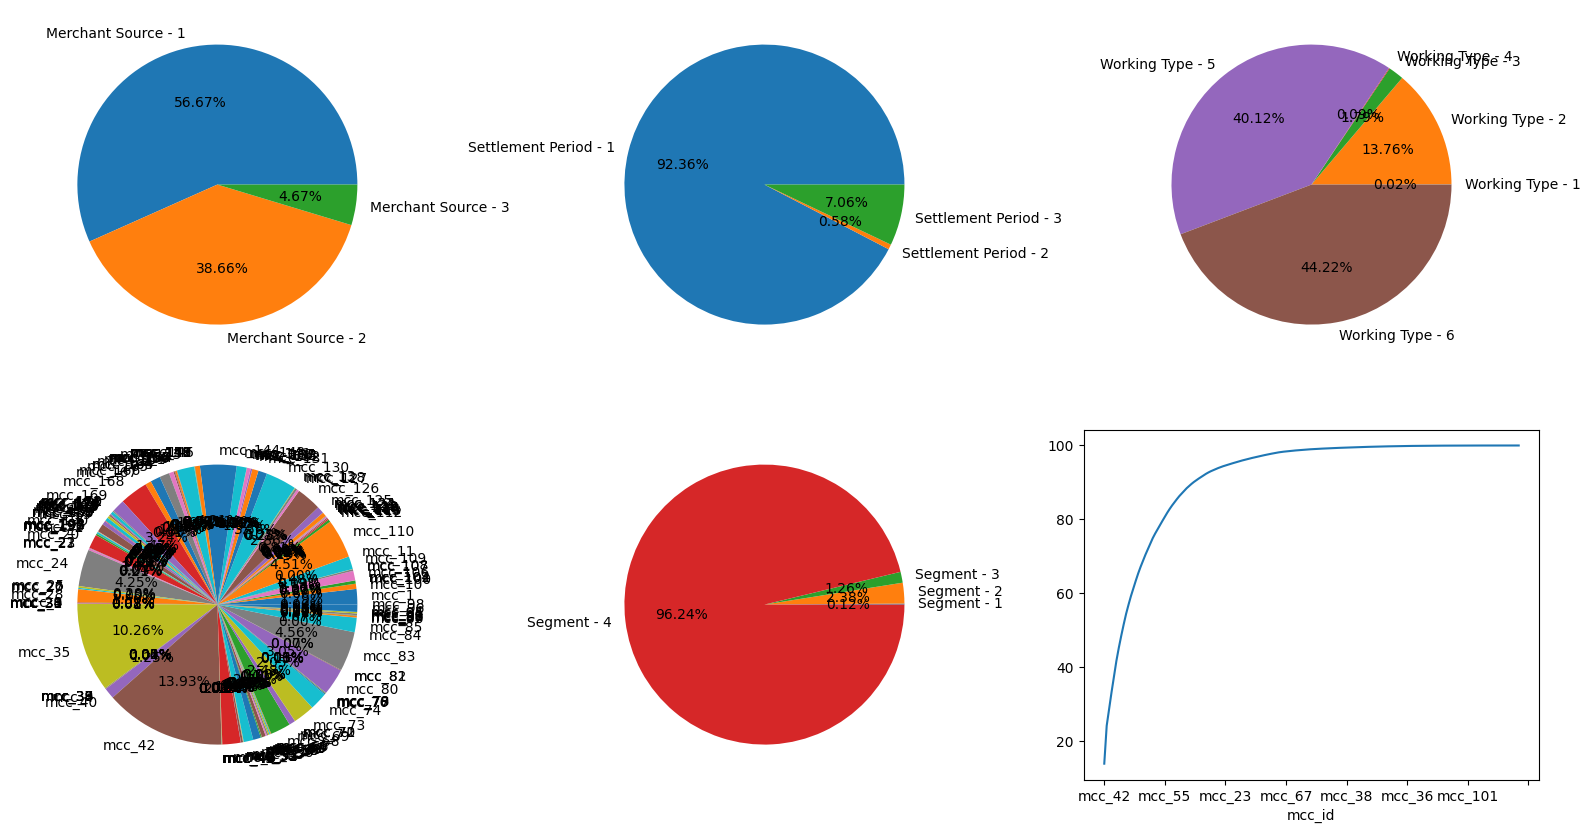

In [114]:
categorical_columns = data.select_dtypes(include='object').drop(columns=["merchant_id"]).columns
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(2, 3, i+1)
    data.groupby(col).size().plot(kind='pie', autopct='%.2f%%', ax=ax)
    
i += 1
ax = fig.add_subplot(2, 3, i+1)
df = data.groupby("mcc_id").size().sort_values(ascending=False)
df = (df / df.sum() * 100)
df.cumsum().plot(ax=ax)

plt.show()

In [227]:
col = "mcc_id"
df = data.groupby(col).size().sort_values(ascending=False)
idx = df.index.tolist().index("mcc_23")
d = dict.fromkeys(df[idx:].index.tolist(), "mcc_O")
mask = data[col].isin(d.keys())
data.loc[mask, col] = data.loc[mask, col].map(d)

col = "merchant_source_name"
df = data.groupby(col).size().sort_values(ascending=False)
idx = df.index.tolist().index("Merchant Source - 2")
d = dict.fromkeys(df[idx:].index.tolist(), "Merchant Source - O")
mask = data[col].isin(d.keys())
data.loc[mask, col] = data.loc[mask, col].map(d)

col = "settlement_period"
df = data.groupby(col).size().sort_values(ascending=False)
idx = df.index.tolist().index("Settlement Period - 3")
d = dict.fromkeys(df[idx:].index.tolist(), "Settlement Period - O")
mask = data[col].isin(d.keys())
data.loc[mask, col] = data.loc[mask, col].map(d)

col = "working_type"
df = data.groupby(col).size().sort_values(ascending=False)
idx = df.index.tolist().index("Working Type - 2")
d = dict.fromkeys(df[idx:].index.tolist(), "Working Type - O")
mask = data[col].isin(d.keys())
data.loc[mask, col] = data.loc[mask, col].map(d)

col = "merchant_segment"
df = data.groupby(col).size().sort_values(ascending=False)
idx = df.index.tolist().index("Segment - 2")
d = dict.fromkeys(df[idx:].index.tolist(), "Segment - O")
mask = data[col].isin(d.keys())
data.loc[mask, col] = data.loc[mask, col].map(d)

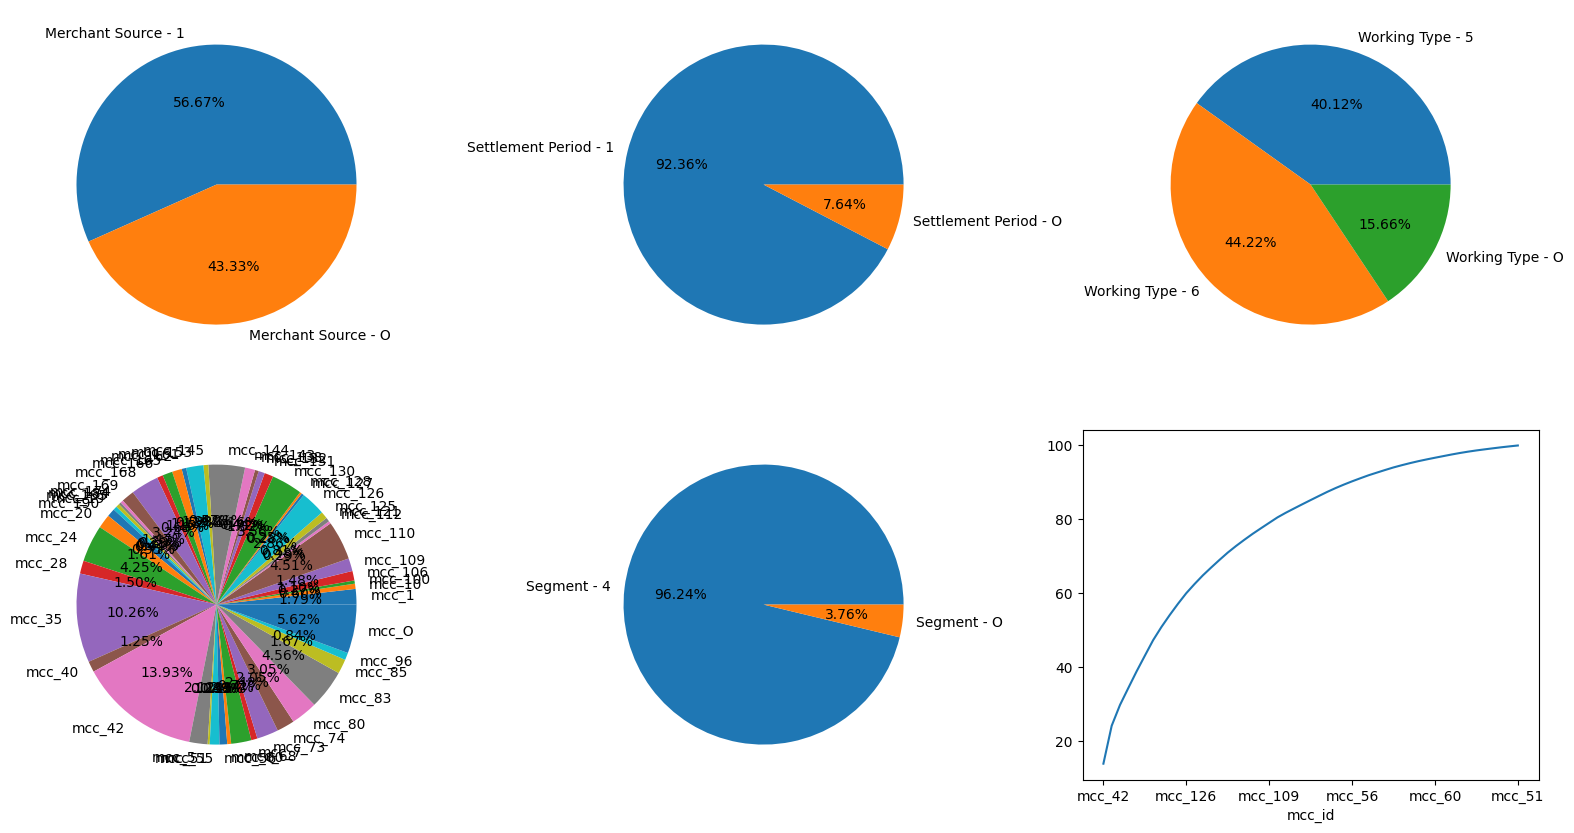

In [192]:
categorical_columns = data.select_dtypes(include='object').drop(columns=["merchant_id"]).columns
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(2, 3, i+1)
    data.groupby(col).size().plot(kind='pie', autopct='%.2f%%', ax=ax)
    
i += 1
ax = fig.add_subplot(2, 3, i+1)
df = data.groupby("mcc_id").size().sort_values(ascending=False)
df = (df / df.sum() * 100)
df.cumsum().plot(ax=ax)

plt.show()

In [402]:
# one-hot encoding categorical columns
data_onehot = pd.get_dummies(data, columns=["merchant_source_name", "settlement_period", "working_type", "mcc_id", "merchant_segment"])
data_onehot.head()

,merchant_id,month_id,net_payment_count,date,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,...,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
0,merchant_43992,202307,15106,42,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,merchant_43992,202301,16918,36,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,merchant_43992,202305,13452,40,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,merchant_43992,202308,16787,43,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,merchant_43992,202302,12428,37,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False


 75.17% of the time-series data is missing.


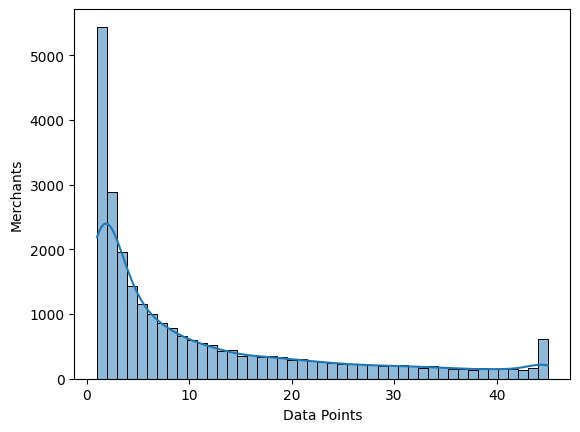

In [3]:
time_series_count = data.groupby("merchant_id").size().reset_index(name="row_count")
ideal_data_points = len(dates)

percentage = (time_series_count["row_count"].sum() / (len(time_series_count) * ideal_data_points)) * 100
print(f"{100-percentage: .2f}% of the time-series data is missing.")

ax = sns.histplot(time_series_count, x="row_count", bins=ideal_data_points, kde=True)
ax.set_xlabel("Data Points")
ax.set_ylabel("Merchants")
plt.show()

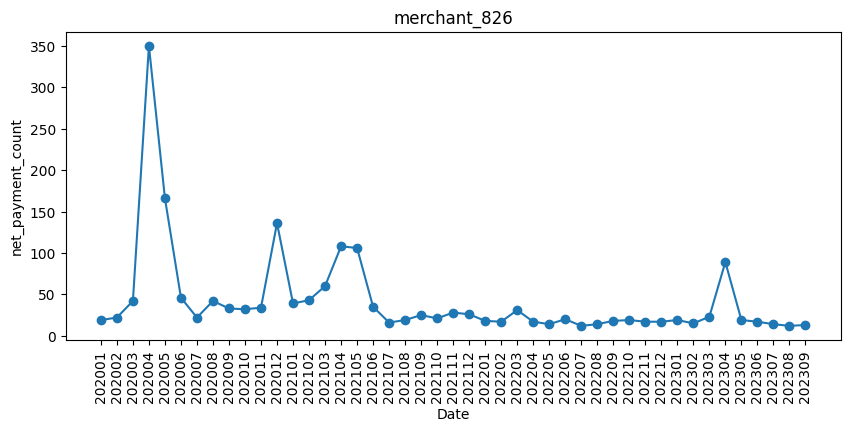

In [43]:
merchant_id = np.random.choice(merchants)
merchant = data[data["merchant_id"] == merchant_id][["net_payment_count", "date"]]
merchant = merchant.set_index("date").reindex(range(45), fill_value=np.nan).reset_index()

plt.figure(figsize=(10, 4))
plt.plot(merchant["date"], merchant["net_payment_count"], '-o')
plt.title(merchant_id)
plt.xlabel("Date")
plt.ylabel("net_payment_count")
plt.xticks(merchant["date"], list(map(str, dates)), rotation=90)
plt.show()

**Outcome:** Ideally, all merchants should have 45 data points, representing all 12 months for 4 years in the time-series data, excluding the last quarter. But an important portion of the merchants have randomly missing data points, therefore a serious imputation technique should be considered to make predictions for the target dates.

In [403]:
# normalization
scaler = StandardScaler()
scaler.fit(data_onehot[["net_payment_count"]])
data_onehot["net_payment_count"] = scaler.transform(data_onehot[["net_payment_count"]])

In [ ]:
INVERSE_DATES_MAP = {45: 202310, 46: 202311, 47: 202312}
data2target = lambda merchant, date: str(INVERSE_DATES_MAP[date]) + merchant

data_dates = pd.get_dummies(data_onehot, columns=["date"])
X_train = data_dates.drop(columns=["merchant_id", "month_id", "net_payment_count"]).values
y_train = data_dates["net_payment_count"].values

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

for merchant in tqdm(merchants):
    merchant_df = data_onehot[data_onehot["merchant_id"] == merchant]
    example_row = merchant_df.iloc[0].copy()
    diff_dates = list(set(DATES_MAP.values()) - set(merchant_df["date"].values))
    for date in diff_dates:
        dates_arr = np.zeros(len(DATES_MAP))
        dates_arr[date] = 1
        X = np.concatenate([example_row.drop(["merchant_id", "month_id", "net_payment_count", "date"]).values, dates_arr])
        y_pred = knn_model.predict([X])[0]
        example_row["date"] = date
        example_row["net_payment_count"] = y_pred
        merchant_df = pd.concat([merchant_df, example_row.to_frame().T], ignore_index=True)
    merchant_df = merchant_df.sort_values(by="date")
    sequence = merchant_df["net_payment_count"].values.astype('float64').tolist()
    date = merchant_df.iloc[-1]["date"] + 1
    for date in range(date, date+3):
        arima_model = ARIMA(sequence, order=(0,0,0)).fit(method_kwargs={"warn_convergence": False})
        prediction = arima_model.forecast()[0]
        sequence.append(prediction)
        prediction = scaler.inverse_transform([[prediction]])[0][0]
        target_data.loc[target_data["id"] == data2target(merchant, date), "net_payment_count"] = prediction

  0%|          | 27/26060 [02:46<38:28:01,  5.32s/it]

In [ ]:
target_data.to_csv("submission_arima.csv", index=False)

In [27]:
X_train, y_train = [], []
window_size = 1

for merchant in tqdm(merchants):
    merchant_df = data_onehot[data_onehot["merchant_id"] == merchant].sort_values(by="date")
    for _, row in merchant_df.iterrows():
        date = row["date"]
        previous_dates = list(range(date - window_size, date))
        previous_payments = merchant_df[merchant_df["date"].isin(previous_dates)]["net_payment_count"].values
        if previous_payments.size > 0:
            X = np.concatenate([row.drop(["merchant_id", "month_id", "date", "net_payment_count"]).values, previous_payments]).tolist()
            X_train.append(X)
            y = row["net_payment_count"]
            y_train.append(y)

100%|██████████| 26060/26060 [30:58<00:00, 14.03it/s] 


In [29]:
with open("data_train_window1.pkl", 'wb') as file:
    pickle.dump((X_train, y_train), file)
    
# with open("data_train_window1.pkl", 'rb') as file:
#     X_train, y_train = pickle.load(file)

In [30]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
with open("random_forest_regressor_window1.pkl", 'wb') as file:
    pickle.dump(model, file)
    
# with open("random_forest_regressor_window1.pkl", 'rb') as file:
#     model = pickle.load(file)

In [126]:
INVERSE_DATES_MAP = {45: 202310, 46: 202311, 47: 202312}
data2target = lambda merchant, date: str(INVERSE_DATES_MAP[date]) + merchant

for merchant in tqdm(merchants):
    merchant_df = data_onehot[data_onehot["merchant_id"] == merchant].sort_values(by="date").iloc[-1]
    date = merchant_df["date"]
    merchant_df = merchant_df.drop(["merchant_id", "month_id", "date"])
    X = np.roll(merchant_df.values, -1)

    predictions = {}
    while date < 47:
        date += 1
        y = model.predict([X])[0]
        y_pred = scaler.inverse_transform([[y]])[0][0]
        predictions[date] = y_pred
        X[-1] = y

    for date in INVERSE_DATES_MAP.keys():
        target_data.loc[target_data["id"] == data2target(merchant, date), "net_payment_count"] = predictions[date]

100%|██████████| 26060/26060 [1:28:40<00:00,  4.90it/s]


In [128]:
target_data.to_csv("submission_rfr_w1.csv", index=False)

target_data.head()

,id,net_payment_count
0,202311merchant_36004,45653.41
1,202312merchant_36004,45630.82
2,202310merchant_36004,43937.24
3,202311merchant_23099,52922.39
4,202312merchant_23099,52877.68


In [270]:
# 100 merchants without a missing value
merchants_ = data["merchant_id"].value_counts()[data["merchant_id"].value_counts() == 45][:100].keys().tolist()
df = data_onehot[data_onehot["merchant_id"].isin(merchants_)]

# reserve last 3 months to recreate the problem
df_val = df[df["month_id"] > 202306]
df = df.drop(df_val.index)

# create random missing data
df_test = df.sample(frac=0.2, random_state=42)
df_train = df.drop(df_test.index)

dates_ = sorted(df["month_id"].unique())
DATES_MAP_ = {date: i for i, date in enumerate(dates_)}

In [271]:
# convert dates into a feature
df_train_dates = pd.get_dummies(df_train, columns=["date"])
X_train = df_train_dates.drop(columns=["merchant_id", "month_id", "net_payment_count"]).values
y_train = df_train_dates["net_payment_count"].values

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

X_test, y_test = [], []

for merchant in tqdm(merchants_):
    for date in DATES_MAP_.values():
        merchant_df = df_train[df_train["merchant_id"] == merchant].drop(columns=["merchant_id", "month_id", "net_payment_count", "date"])
        check_df = df_train[(df_train["merchant_id"] == merchant) & (df_train["date"] == date)]
        if check_df.empty:
            dates_arr = np.zeros(42)
            dates_arr[date] = 1
            X = np.concatenate([merchant_df.values[0], dates_arr])
            X_test.append(X)
            y = df_test[(df_test["merchant_id"] == merchant) & (df_test["date"] == date)]["net_payment_count"].values
            y_test.append(scaler.inverse_transform([y])[0][0])

y_pred = scaler.inverse_transform([model.predict(X_test)])[0]
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


MAE: 1995.0471428571432


In [369]:
df_train_dates = pd.get_dummies(df_train, columns=["date"])
X_train = df_train_dates.drop(columns=["merchant_id", "month_id", "net_payment_count"]).values
y_train = df_train_dates["net_payment_count"].values

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

predictions, y_val = [], []

for merchant in tqdm(merchants_):
    merchant_df = df_train[df_train["merchant_id"] == merchant]
    example_row = merchant_df.iloc[0].copy()
    diff_dates = list(set(DATES_MAP_.values()) - set(merchant_df["date"].values))
    for date in diff_dates:
        dates_arr = np.zeros(len(DATES_MAP_))
        dates_arr[date] = 1
        X = np.concatenate([example_row.drop(["merchant_id", "month_id", "net_payment_count", "date"]).values, dates_arr])
        y_pred = knn_model.predict([X])[0]
        example_row["date"] = date
        example_row["net_payment_count"] = y_pred
        merchant_df = pd.concat([merchant_df, example_row.to_frame().T], ignore_index=True)
    merchant_df = merchant_df.sort_values(by="date")
    sequence = merchant_df["net_payment_count"].values.astype('float64').tolist()
    date = merchant_df.iloc[-1]["date"] + 1
    for date in range(date, date+3):
        arima_model = ARIMA(sequence, order=(0,0,0)).fit(method_kwargs={"warn_convergence": False})
        prediction = arima_model.forecast()[0]
        predictions.append(scaler.inverse_transform([[prediction]])[0][0])
        sequence.append(prediction)
        y = df_val[(df_val["merchant_id"] == merchant) & (df_val["date"] == date)]["net_payment_count"].values[0]
        y_val.append(scaler.inverse_transform([[y]])[0][0])

mae = mean_absolute_error(y_val, predictions)
print(f"MAE: {mae}")

100%|██████████| 100/100 [00:26<00:00,  3.71it/s]

MAE: 5640.701504022061


In [360]:
df_val[df_val["merchant_id"] == merchant]

,merchant_id,month_id,net_payment_count,date,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,...,mcc_id_mcc_92,mcc_id_mcc_93,mcc_id_mcc_94,mcc_id_mcc_95,mcc_id_mcc_96,mcc_id_mcc_98,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
0,merchant_43992,202307,1.357646,42,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,merchant_43992,202308,1.512997,43,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
14,merchant_43992,202309,1.628979,44,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [332]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sequence, order=(5,0,1)).fit()
model.forecast()

array([0.95573764])

In [197]:
sample = df_test.iloc[40]

merchant_id = sample["merchant_id"]
month_id = sample["month_id"]

sample_X = df_train[(df_train["merchant_id"] == merchant_id) & (df_train["date"] == DATES_MAP[month_id]-1)].drop(columns=["merchant_id", "month_id", "date"]).values[0]
sample_y = df_test[(df_test["merchant_id"] == merchant_id) & (df_test["month_id"] == month_id)]["net_payment_count"].values[0]

In [199]:
sample_y

11

In [18]:
X_train = []
y_train = []
for i, row in df_train.iterrows():
    next_row = df_train[(df_train["merchant_id"] == row["merchant_id"]) & (df_train["date"] == row["date"] + 1)]
    if not next_row.empty:
        X_train.append(row.drop(["merchant_id", "month_id", "date"]).tolist())
        y_train.append(next_row["net_payment_count"].values[0])

# date = 202210
# data_ex = df_train[df_train["month_id"] == date]
# data_ex_y = data_ex["net_payment_count"]
# data_ex_X = data_ex.drop(columns=["merchant_id", "month_id", "net_payment_count"])

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# merchant = "merchant_86"
# merchant_ex = df_train[df_train["merchant_id"] == merchant].iloc[0].to_frame().T.drop(columns=["merchant_id", "month_id", "net_payment_count"])
# if df_train[(df_train["merchant_id"] == merchant) & (df_train["month_id"] == date)].empty:
#     pred = model.predict(merchant_ex)
# print(pred)
# print(df_test[(df_test["merchant_id"] == merchant) & (df_test["month_id"] == date)]["net_payment_count"].to_numpy())

RandomForestRegressor(random_state=42)

In [200]:
pred = model.predict([sample_X])
print(pred)
print(sample_y)

[9.39133333]
11


In [135]:
X_train[0]

['merchant_43992',
 202301,
 16918,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [103]:
# data["month_id"] = data["month_id"].astype(str)

dates = sorted(data["month_id"].unique()) # All dates for 4 years except the last Q4
merchants = data["merchant_id"].unique() # All unique merchants

for merchant in tqdm(merchants):
    merchant_ex = data[data['merchant_id'] == merchant].iloc[0].to_frame().T
    merchant_ex["net_payment_count"] = None
    merchant_dates = data[data['merchant_id'] == merchant]['month_id']
    # find missing values
    for date in dates:
        if date not in merchant_dates:
            merchant_ex["month_id"] = date
            data = pd.concat([data, merchant_ex])

  3%|▎         | 903/26060 [17:43<8:13:56,  1.18s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_42/337389726.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1172, in structured_traceback
    formatted_exception = self.format_exce

In [146]:
dates

[202001,
 202002,
 202003,
 202004,
 202005,
 202006,
 202007,
 202008,
 202009,
 202010,
 202011,
 202012,
 202101,
 202102,
 202103,
 202104,
 202105,
 202106,
 202107,
 202108,
 202109,
 202110,
 202111,
 202112,
 202201,
 202202,
 202203,
 202204,
 202205,
 202206,
 202207,
 202208,
 202209,
 202210,
 202211,
 202212,
 202301,
 202302,
 202303,
 202304,
 202305,
 202306,
 202307,
 202308,
 202309]

In [99]:
a = data[data['merchant_id'] == "merchant_43992"]['month_id']

In [50]:
target_data
target_data["id"].apply(lambda x: x[6:]).value_counts()

id
merchant_36004    3
merchant_26499    3
merchant_22413    3
merchant_40493    3
merchant_20996    3
                 ..
merchant_52716    3
merchant_13959    3
merchant_54283    3
merchant_19892    3
merchant_8429     3
Name: count, Length: 26060, dtype: int64

In [28]:
data.sort_values(by=["merchant_id", "month_id"])

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
234370,merchant_1,202108,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
234371,merchant_1,202210,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
249229,merchant_10,202111,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,6
249226,merchant_10,202112,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,24
249224,merchant_10,202201,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,15
...,...,...,...,...,...,...,...,...
277532,merchant_9993,202211,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277533,merchant_9993,202212,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277531,merchant_9993,202301,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277530,merchant_9993,202302,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3


In [63]:
data[data["merchant_id"]=="merchant_17200"].describe(include='all')

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
count,45,45.000000,45,45,45,45,45,45.000000
unique,1,NaN,1,1,1,1,1,NaN
top,merchant_17200,NaN,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_165,Segment - 4,NaN
freq,45,NaN,45,45,45,45,45,NaN
mean,NaN,202146.200000,NaN,NaN,NaN,NaN,NaN,60.933333
std,NaN,109.148065,NaN,NaN,NaN,NaN,NaN,77.234707
min,NaN,202001.000000,NaN,NaN,NaN,NaN,NaN,3.000000
25%,NaN,202012.000000,NaN,NaN,NaN,NaN,NaN,8.000000
50%,NaN,202111.000000,NaN,NaN,NaN,NaN,NaN,36.000000
75%,NaN,202210.000000,NaN,NaN,NaN,NaN,NaN,76.000000


In [60]:
data["merchant_id"].value_counts()

merchant_id
merchant_43992    45
merchant_19380    45
merchant_1100     45
merchant_17200    45
merchant_65293    45
                  ..
merchant_3063      1
merchant_35756     1
merchant_50399     1
merchant_56272     1
merchant_66895     1
Name: count, Length: 26060, dtype: int64

In [115]:
data["merchant_id"].value_counts().value_counts().sort_index()

count
1     5442
2     2890
3     1953
4     1430
5     1149
6     1001
7      867
8      789
9      664
10     604
11     556
12     525
13     427
14     439
15     351
16     368
17     340
18     352
19     338
20     284
21     303
22     275
23     260
24     248
25     232
26     224
27     221
28     214
29     191
30     211
31     208
32     194
33     166
34     190
35     179
36     157
37     156
38     135
39     160
40     157
41     144
42     153
43     137
44     162
45     614
Name: count, dtype: int64